In [1]:
import torch

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
from transformers import Mask2FormerForUniversalSegmentation, Mask2FormerImageProcessor

def get_pretrained_model(verbose=False):
    """
    Get the Mask2Former model for binary segmentation
    
    COPIED DIRECTLY FROM train.ipynb
    :return: Mask2Former model for binary segmentation and the image processor
    """
    
    # Load the image processor with relevant settings
    # COPIED DIRECTLY FROM train.ipynb
    image_processor = Mask2FormerImageProcessor.from_pretrained(
        "facebook/mask2former-swin-base-IN21k-ade-semantic",
        do_rescale=True,   # Skip rescaling if images are already normalized
        do_normalize=False,  # DO NOT NORMALIZE. POOR RESULTS FOR BINARY SEGMENATATION.
        do_resize=True     # Skip resizing as we're handling this during preprocessing
    )
    
    # Load the Mask2Former model for binary segmentation
    model = Mask2FormerForUniversalSegmentation.from_pretrained(
        "facebook/mask2former-swin-base-IN21k-ade-semantic",
        num_labels=2,                     # Binary segmentation (background and tissue)
        ignore_mismatched_sizes=True      # Allow resizing of model parameters if dimensions do not match
    )
    
    ###############################################
    # Freezing encoder backbone if desired
    ###############################################
    
    # Freeze the backbone of the Mask2Former model
    for name, param in model.named_parameters():
        if "encoder" in name:  # Match all layers within the encoder (backbone)
            param.requires_grad = False
    
    # Display the trainable layers for confirmation
    # Print trainable layers
    if verbose:
        for name, param in model.named_parameters():
            if param.requires_grad:
                print(f"{name} is trainable")
            else:
                print(f"{name} is frozen")
            
    return model, image_processor

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-25 15:49:49.522845: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-25 15:49:49.539787: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-25 15:49:49.545012: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
_, _ = get_pretrained_model()

/home/ubuntu/.local/lib/python3.10/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)
Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-IN21k-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
from loss import *


def calculate_metrics(output, target):
    predicted_masks = (output > 0.5).cpu().numpy().astype(np.uint8)
    ground_truth_masks_np = target.cpu().numpy().astype(np.uint8)

    # Compute metrics
    num_samples = 0
    total_iou = 0
    total_dice = 0
    for pred, gt in zip(predicted_masks, ground_truth_masks_np):
        total_iou += calculate_iou_infer(pred, gt)
        total_dice += calculate_dice_infer(pred, gt)
        num_samples += 1

    # Calculate pixel accuracy
    matching_pixels = torch.tensor(predicted_masks == ground_truth_masks_np).sum()  # Count matching pixels per batch
    
    # Total number of pixels per batch
    total_pixels = torch.tensor(predicted_masks).numel()
    
    # Calculate pixel accuracy per batch
    pixel_accuracy = float(matching_pixels) / total_pixels

    # Calculate average loss and metrics
    avg_iou = total_iou / num_samples if num_samples > 0 else 0
    avg_dice = total_dice / num_samples if num_samples > 0 else 0

    return avg_iou, avg_dice, pixel_accuracy
    


def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, device="cuda"):
    """
    Training function with integrated validation after each epoch.

    Args:
        model: The segmentation model to train.
        train_loader: DataLoader providing training images and masks.
        val_loader: DataLoader providing validation images and masks.
        criterion: Loss function for training and validation.
        optimizer: Optimizer for updating model weights.
        num_epochs: Number of training epochs.
        device: Computation device (CPU or CUDA).
    """
    train_metrics = {'loss': [], 'iou': [], 'dice': [], 'pixel_acc': []}
    val_metrics = {'loss': [], 'iou': [], 'dice': [], 'pixel_acc': []}
    model.to(device)
    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()
        running_loss = 0.0
        running_iou = 0.0
        running_dice = 0.0
        running_pixel_acc = 0.0

        for pixel_values, masks in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training"):
        
            
            # Move inputs and masks to the correct device
            pixel_values = pixel_values.to(device, dtype=next(model.parameters()).dtype)  # Match model dtype
            masks = masks.to(device, dtype=torch.float32)  # Ensure masks are on the correct device and float32

            # Forward pass
            outputs = model(pixel_values=pixel_values)
            tissue_logits = outputs.masks_queries_logits[:, 1]  # Binary segmentation logits

            # Resize logits to match masks
            tissue_logits_resized = torch.sigmoid(F.interpolate(
                tissue_logits.unsqueeze(1),  # Add channel dimension
                size=masks.shape[-2:],  # Match mask size
                mode="bilinear",
                align_corners=False
            ))  # Remove channel dimension

            # Compute loss
            loss = criterion(tissue_logits_resized, masks)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()

            # Calculate metrics
            iou, dice, pixel_accuracy = calculate_metrics(tissue_logits_resized, masks)
            running_iou += iou
            running_dice += dice
            running_pixel_acc += pixel_accuracy

        # Average training metrics
        avg_train_loss = running_loss / len(train_loader)
        avg_train_iou = running_iou / len(train_loader)
        avg_train_dice = running_dice / len(train_loader)
        avg_train_pixel_accuracy = running_pixel_acc / len(train_loader)
        train_metrics['loss'].append(avg_train_loss)
        train_metrics['iou'].append(avg_train_iou)
        train_metrics['dice'].append(avg_train_dice)
        train_metrics['pixel_acc'].append(avg_train_pixel_accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training IoU: {avg_train_iou:.4f}, Training Dice: {avg_train_dice:.4f}, Training Pixel Acc: {avg_train_pixel_accuracy:.4f}")

        # Perform validation
        avg_val_loss, avg_iou, avg_dice, avg_pixel_acc = validate(model, val_loader, criterion, device)
        val_metrics['loss'].append(avg_val_loss)
        val_metrics['iou'].append(avg_iou)
        val_metrics['dice'].append(avg_dice)
        val_metrics['pixel_acc'].append(avg_pixel_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] Validation - Loss: {avg_val_loss:.4f}, IoU: {avg_iou:.4f}, Dice: {avg_dice:.4f}, Pixel acc: {avg_pixel_acc}\n")

        # Stop criteria
        if avg_train_iou < 0.3:
            print("Stopping criteria: not enough potential!")
            return train_metrics, val_metrics
    
    return train_metrics, val_metrics


def validate(model, val_loader, criterion, device):
    """
    Validation function aligned with inference logic, including IoU and Dice metric calculation.

    Args:
        model: The trained segmentation model.
        val_loader: DataLoader providing validation images and ground truth masks.
        criterion: Loss function for evaluation.
        device: Computation device (CPU or CUDA).

    Returns:
        avg_val_loss: Average validation loss.
        avg_iou: Average IoU across the validation set.
        avg_dice: Average Dice score across the validation set.
    """
    model.eval()
    val_loss = 0.0
    total_iou = 0.0
    total_dice = 0.0
    total_pixel_acc = 0.0
    num_samples = 0

    with torch.no_grad():
        for images, ground_truth_masks in tqdm(val_loader, desc="Validation"):
            # Move inputs and masks to the correct device
            images = images.to(device)
            ground_truth_masks = ground_truth_masks.to(device, dtype=torch.float32)

            # Forward pass
            outputs = model(pixel_values=images)
            tissue_logits = outputs.masks_queries_logits[:, 1]  # Binary segmentation logits

            # Resize logits to match mask size
            tissue_logits_resized = torch.sigmoid(F.interpolate(
                tissue_logits.unsqueeze(1),  # Add channel dimension
                size=ground_truth_masks.shape[-2:],  # Match mask size
                mode="bilinear",
                align_corners=False
            ))  # Remove channel dimension

            # Compute loss
            loss = criterion(tissue_logits_resized, ground_truth_masks)
            val_loss += loss.item()

            # Convert predicted logits to binary masks
            predicted_masks = (tissue_logits_resized > 0.5).cpu().numpy().astype(np.uint8)
            ground_truth_masks_np = ground_truth_masks.cpu().numpy().astype(np.uint8)

            # Compute metrics
            for pred, gt in zip(predicted_masks, ground_truth_masks_np):
                total_iou += calculate_iou_infer(pred, gt)
                total_dice += calculate_dice_infer(pred, gt)
                num_samples += 1

            matching_pixels = (predicted_masks == ground_truth_masks_np).sum()  # Count matching pixels per batch
            total_pixels = torch.tensor(predicted_masks).numel()
            total_pixel_acc += float(matching_pixels) / total_pixels

    # Calculate average loss and metrics
    avg_val_loss = val_loss / len(val_loader)
    avg_val_pixel_acc = total_pixel_acc / len(val_loader)
    avg_iou = total_iou / num_samples if num_samples > 0 else 0
    avg_dice = total_dice / num_samples if num_samples > 0 else 0

    return avg_val_loss, avg_iou, avg_dice, avg_val_pixel_acc

In [5]:
import optuna
#from train import train, validate 
from preprocess import create_dataloaders
from torch import optim
from loss import CombinedDiceBCELoss, DiceLoss, ScaledDiceLoss, BoundaryDiceLoss

IMAGE_FOLDER = 'data/Huron_data/Sliced_Images/'
MASK_FOLDER = 'data/Huron_data/Sliced_masks/'
NUM_EPOCHS_PER_TRIAL = 5

metrics = []

def objective(trial):
    print('Starting trial')

    try:
        ## Define the general hyperparameters
        print('Defining hyperparameters')
        criterions = trial.suggest_categorical('criterion', ['combined', 'dice', 'scaled', 'boundary'])
        use_batch = trial.suggest_categorical('use_batches', ['true', 'false'])
        if use_batch == 'true':
            batch_size = trial.suggest_int('batch_size', 4, 16)
        else:
            batch_size = 1
        
        ## Get the model
        print("Creating model and image processor")
        model, image_processor = get_pretrained_model()
    
        ## Get the dataloaders
        print("Creating dataloaders")
        train_loader, val_loader, _, _, _ = create_dataloaders(IMAGE_FOLDER, MASK_FOLDER, batch_size, image_processor, divide=10)
    
        ## Define the optimizer and loss function
        print("Defining optimizer")
        #lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
        weight_decay = trial.suggest_float('weight_decay', 1e-4, 1e-2, log=True)
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=weight_decay)
            
        ## Define the loss function
        print("Defining loss function")
        smooth = trial.suggest_float('smooth', 1e-6, 1.0, log=True)
        if criterions == 'combined':
            dice_weight = trial.suggest_float('dice_weight_combined', 0.1, 0.9)
            loss = CombinedDiceBCELoss(dice_weight, 1-dice_weight, smooth)
        elif criterions == 'dice':
            loss = DiceLoss(smooth)
        elif criterions == 'scaled':
            threshold_low_loss = trial.suggest_int('threshold_low_loss', 1, 50)
            loss = ScaledDiceLoss(smooth, threshold_low_loss)
        elif criterions == 'boundary':
            threshold_low_loss = trial.suggest_int('threshold_low_loss', 1, 50)
            boundary_weight = trial.suggest_float('boundary_weight', 0.01, 10, log=True)
            loss = BoundaryDiceLoss(smooth, boundary_weight, threshold_low_loss)
        else:
            raise ValueError("Invalid criterion")
    
        ## Train the model
        print("Starting training")
        train_metrics, val_metrics = train(model, train_loader, val_loader, loss, optimizer, NUM_EPOCHS_PER_TRIAL, device)
    
        ## Validation
        print("Starting validation")
        avg_val_loss, avg_iou, avg_dice, avg_val_pixel_acc = validate(model, val_loader, loss, device)
        print(f"Validation Loss: {avg_val_loss}, IoU: {avg_iou}, Dice: {avg_dice}, Pixel accuracy: {avg_val_pixel_acc}")
        
        print("Trial complete")
    
        # clean cache
        del model, optimizer, image_processor, loss
        torch.cuda.empty_cache()
    
        # add metrics to list
        metrics.append({
            "trial": trial,
            "train": train_metrics,
            "val": val_metrics
        })
        
        return avg_iou
    except Exception as e:
        print("Error running trial. It will be skiped.")
        print(e)
        return 0

In [8]:
NUM_TRIALS = 30

print(f"Estimated completion time of {NUM_TRIALS*NUM_EPOCHS_PER_TRIAL / 60:.2f} hours") 

Estimated completion time of 2.50 hours


In [ ]:
# Create study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=NUM_TRIALS, gc_after_trial=True)

[I 2024-11-25 15:52:36,917] A new study created in memory with name: no-name-031225e9-9719-4d20-b06d-994546c72eb8


Starting trial
Defining hyperparameters
Creating model and image processor


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-IN21k-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Creating dataloaders
Defining optimizer
Defining loss function
Starting training


Epoch [1/5] Training: 100%|██████████| 1387/1387 [02:49<00:00,  8.20it/s]


Epoch [1/5], Training Loss: 0.3450, Training IoU: 0.6109, Training Dice: 0.7085, Training Pixel Acc: 0.9492


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.26it/s]


Epoch [1/5] Validation - Loss: 0.2746, IoU: 0.6884, Dice: 0.7857, Pixel acc: 0.9727653041696686



Epoch [2/5] Training: 100%|██████████| 1387/1387 [02:47<00:00,  8.28it/s]


Epoch [2/5], Training Loss: 0.2826, Training IoU: 0.6779, Training Dice: 0.7723, Training Pixel Acc: 0.9621


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.27it/s]


Epoch [2/5] Validation - Loss: 0.2967, IoU: 0.6470, Dice: 0.7567, Pixel acc: 0.9609513956119417



Epoch [3/5] Training: 100%|██████████| 1387/1387 [02:48<00:00,  8.25it/s]


Epoch [3/5], Training Loss: 0.2572, Training IoU: 0.7111, Training Dice: 0.8029, Training Pixel Acc: 0.9658


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.44it/s]


Epoch [3/5] Validation - Loss: 0.2320, IoU: 0.7371, Dice: 0.8286, Pixel acc: 0.9762395589427233



Epoch [4/5] Training: 100%|██████████| 1387/1387 [02:46<00:00,  8.34it/s]


Epoch [4/5], Training Loss: 0.2391, Training IoU: 0.7310, Training Dice: 0.8204, Training Pixel Acc: 0.9698


Validation: 100%|██████████| 347/347 [00:31<00:00, 11.04it/s]


Epoch [4/5] Validation - Loss: 0.2277, IoU: 0.7480, Dice: 0.8365, Pixel acc: 0.9777963951616535



Epoch [5/5] Training: 100%|██████████| 1387/1387 [02:46<00:00,  8.33it/s]


Epoch [5/5], Training Loss: 0.2319, Training IoU: 0.7418, Training Dice: 0.8293, Training Pixel Acc: 0.9714


Validation: 100%|██████████| 347/347 [00:31<00:00, 10.90it/s]


Epoch [5/5] Validation - Loss: 0.2429, IoU: 0.7238, Dice: 0.8163, Pixel acc: 0.9742596980817724

Starting validation


Validation: 100%|██████████| 347/347 [00:31<00:00, 10.88it/s]
[I 2024-11-25 16:09:43,807] Trial 0 finished with value: 0.7238011772726863 and parameters: {'criterion': 'combined', 'use_batches': 'false', 'weight_decay': 0.0008610650866191089, 'smooth': 2.8842728484186537e-05, 'dice_weight_combined': 0.8759576133277219}. Best is trial 0 with value: 0.7238011772726863.


Validation Loss: 0.24286639339341554, IoU: 0.7238011772726863, Dice: 0.8163238340506196, Pixel accuracy: 0.9742596980817724
Trial complete
Starting trial
Defining hyperparameters
Creating model and image processor


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-IN21k-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Creating dataloaders
Defining optimizer
Defining loss function
Starting training


Epoch [1/5] Training: 100%|██████████| 1387/1387 [02:49<00:00,  8.17it/s]


Epoch [1/5], Training Loss: nan, Training IoU: 0.0922, Training Dice: 0.0934, Training Pixel Acc: 0.8745


Epoch [1/5] Training: 100%|██████████| 1387/1387 [02:48<00:00,  8.22it/s]


Epoch [1/5], Training Loss: 0.2755, Training IoU: 0.6379, Training Dice: 0.7355, Training Pixel Acc: 0.9494


Validation: 100%|██████████| 347/347 [00:31<00:00, 11.08it/s]


Epoch [1/5] Validation - Loss: 0.2137, IoU: 0.6783, Dice: 0.7700, Pixel acc: 0.9756781058627522



Epoch [2/5] Training: 100%|██████████| 1387/1387 [02:49<00:00,  8.16it/s]


Epoch [2/5], Training Loss: 0.2035, Training IoU: 0.7196, Training Dice: 0.8117, Training Pixel Acc: 0.9688


Validation: 100%|██████████| 347/347 [00:31<00:00, 10.90it/s]


Epoch [2/5] Validation - Loss: 0.1672, IoU: 0.7491, Dice: 0.8349, Pixel acc: 0.9775837395307997



Epoch [3/5] Training: 100%|██████████| 1387/1387 [02:51<00:00,  8.08it/s]


Epoch [3/5], Training Loss: 0.1979, Training IoU: 0.7215, Training Dice: 0.8108, Training Pixel Acc: 0.9691


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.29it/s]


Epoch [3/5] Validation - Loss: 0.1694, IoU: 0.7366, Dice: 0.8225, Pixel acc: 0.979080244168768



Epoch [4/5] Training: 100%|██████████| 1387/1387 [02:51<00:00,  8.10it/s]


Epoch [4/5], Training Loss: 0.1809, Training IoU: 0.7453, Training Dice: 0.8328, Training Pixel Acc: 0.9727


Validation: 100%|██████████| 347/347 [00:31<00:00, 11.15it/s]


Epoch [4/5] Validation - Loss: 0.1670, IoU: 0.7609, Dice: 0.8456, Pixel acc: 0.9778767786383286



Epoch [5/5] Training: 100%|██████████| 1387/1387 [02:47<00:00,  8.26it/s]


Epoch [5/5], Training Loss: 0.1786, Training IoU: 0.7449, Training Dice: 0.8314, Training Pixel Acc: 0.9735


Validation: 100%|██████████| 347/347 [00:31<00:00, 11.01it/s]


Epoch [5/5] Validation - Loss: 0.1673, IoU: 0.7527, Dice: 0.8358, Pixel acc: 0.9788732171402197

Starting validation


Validation: 100%|██████████| 347/347 [00:32<00:00, 10.81it/s]
[I 2024-11-25 16:30:59,007] Trial 2 finished with value: 0.7527289400057015 and parameters: {'criterion': 'boundary', 'use_batches': 'false', 'weight_decay': 0.007912521516055822, 'smooth': 0.1367658814651175, 'threshold_low_loss': 22, 'boundary_weight': 0.04640222063499076}. Best is trial 2 with value: 0.7527289400057015.


Validation Loss: 0.1672847243540944, IoU: 0.7527289400057015, Dice: 0.8358379259521929, Pixel accuracy: 0.9788732171402197
Trial complete
Starting trial
Defining hyperparameters
Creating model and image processor


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-IN21k-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Creating dataloaders
Defining optimizer
Defining loss function
Starting training


Epoch [1/5] Training: 100%|██████████| 87/87 [01:27<00:00,  1.00s/it]


Epoch [1/5], Training Loss: 0.3789, Training IoU: 0.5226, Training Dice: 0.6197, Training Pixel Acc: 0.9279


Validation: 100%|██████████| 22/22 [00:18<00:00,  1.17it/s]


Epoch [1/5] Validation - Loss: 0.2653, IoU: 0.6939, Dice: 0.7884, Pixel acc: 0.970757208579828



Epoch [2/5] Training: 100%|██████████| 87/87 [01:27<00:00,  1.00s/it]


Epoch [2/5], Training Loss: 0.3161, Training IoU: 0.6184, Training Dice: 0.7206, Training Pixel Acc: 0.9588


Validation: 100%|██████████| 22/22 [00:18<00:00,  1.18it/s]


Epoch [2/5] Validation - Loss: 0.2577, IoU: 0.7316, Dice: 0.8214, Pixel acc: 0.9735222966217798



Epoch [3/5] Training: 100%|██████████| 87/87 [01:26<00:00,  1.00it/s]


Epoch [3/5], Training Loss: 0.2822, Training IoU: 0.6620, Training Dice: 0.7593, Training Pixel Acc: 0.9666


Validation: 100%|██████████| 22/22 [00:18<00:00,  1.17it/s]


Epoch [3/5] Validation - Loss: 0.2530, IoU: 0.7251, Dice: 0.8138, Pixel acc: 0.9751697098913272



Epoch [4/5] Training: 100%|██████████| 87/87 [01:26<00:00,  1.00it/s]


Epoch [4/5], Training Loss: 0.2731, Training IoU: 0.6835, Training Dice: 0.7771, Training Pixel Acc: 0.9688


Validation: 100%|██████████| 22/22 [00:18<00:00,  1.18it/s]


Epoch [4/5] Validation - Loss: 0.2599, IoU: 0.7190, Dice: 0.8084, Pixel acc: 0.9736605715160528



Epoch [5/5] Training: 100%|██████████| 87/87 [01:26<00:00,  1.00it/s]


Epoch [5/5], Training Loss: 0.2683, Training IoU: 0.6889, Training Dice: 0.7815, Training Pixel Acc: 0.9705


Validation: 100%|██████████| 22/22 [00:18<00:00,  1.17it/s]


Epoch [5/5] Validation - Loss: 0.2524, IoU: 0.7250, Dice: 0.8096, Pixel acc: 0.9744802112421713

Starting validation


Validation: 100%|██████████| 22/22 [00:18<00:00,  1.18it/s]
[I 2024-11-25 16:40:08,757] Trial 3 finished with value: 0.7249680179702263 and parameters: {'criterion': 'combined', 'use_batches': 'true', 'batch_size': 16, 'weight_decay': 0.0005923532344144861, 'smooth': 0.050496890725629, 'dice_weight_combined': 0.7382617643287424}. Best is trial 2 with value: 0.7527289400057015.


Validation Loss: 0.25243032520467584, IoU: 0.7249680179702263, Dice: 0.8095810217698594, Pixel accuracy: 0.9744802112421713
Trial complete
Starting trial
Defining hyperparameters
Creating model and image processor


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-IN21k-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Creating dataloaders
Defining optimizer
Defining loss function
Starting training


Epoch [1/5] Training: 100%|██████████| 278/278 [01:36<00:00,  2.89it/s]


Epoch [1/5], Training Loss: 0.8165, Training IoU: 0.0888, Training Dice: 0.0891, Training Pixel Acc: 0.8725


Validation: 100%|██████████| 70/70 [00:20<00:00,  3.49it/s]


Epoch [1/5] Validation - Loss: 0.8145, IoU: 0.0865, Dice: 0.0865, Pixel acc: 0.8652457101004464

Stopping criteria: not enough potential!
Starting validation


Validation: 100%|██████████| 70/70 [00:19<00:00,  3.50it/s]
[I 2024-11-25 16:42:27,213] Trial 4 finished with value: 0.08645533141210375 and parameters: {'criterion': 'combined', 'use_batches': 'true', 'batch_size': 5, 'weight_decay': 0.008533763343593665, 'smooth': 1.02635214767426e-06, 'dice_weight_combined': 0.3955132767976718}. Best is trial 2 with value: 0.7527289400057015.


Validation Loss: 0.8145117734159742, IoU: 0.08645533141210375, Dice: 0.08645533141210375, Pixel accuracy: 0.8652457101004464
Trial complete
Starting trial
Defining hyperparameters
Creating model and image processor


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-IN21k-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Creating dataloaders
Defining optimizer
Defining loss function
Starting training


Epoch [1/5] Training: 100%|██████████| 1387/1387 [02:49<00:00,  8.19it/s]


Epoch [1/5], Training Loss: 0.3995, Training IoU: 0.6105, Training Dice: 0.7109, Training Pixel Acc: 0.9520


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.36it/s]


Epoch [1/5] Validation - Loss: 0.3144, IoU: 0.7211, Dice: 0.8164, Pixel acc: 0.9707198349130943



Epoch [2/5] Training: 100%|██████████| 1387/1387 [02:49<00:00,  8.17it/s]


Epoch [2/5], Training Loss: 0.3327, Training IoU: 0.7005, Training Dice: 0.7950, Training Pixel Acc: 0.9672


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.36it/s]


Epoch [2/5] Validation - Loss: 0.2921, IoU: 0.7586, Dice: 0.8460, Pixel acc: 0.974384406801603



Epoch [3/5] Training: 100%|██████████| 1387/1387 [02:47<00:00,  8.30it/s]


Epoch [3/5], Training Loss: 0.3232, Training IoU: 0.7145, Training Dice: 0.8071, Training Pixel Acc: 0.9688


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.30it/s]


Epoch [3/5] Validation - Loss: 0.3159, IoU: 0.7239, Dice: 0.8169, Pixel acc: 0.9698964759320965



Epoch [4/5] Training: 100%|██████████| 1387/1387 [02:45<00:00,  8.37it/s]


Epoch [4/5], Training Loss: 0.3136, Training IoU: 0.7285, Training Dice: 0.8188, Training Pixel Acc: 0.9706


Validation: 100%|██████████| 347/347 [00:31<00:00, 11.18it/s]


Epoch [4/5] Validation - Loss: 0.3123, IoU: 0.7342, Dice: 0.8252, Pixel acc: 0.9719361406925432



Epoch [5/5] Training: 100%|██████████| 1387/1387 [02:48<00:00,  8.22it/s]


Epoch [5/5], Training Loss: 0.3135, Training IoU: 0.7272, Training Dice: 0.8181, Training Pixel Acc: 0.9710


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.20it/s]


Epoch [5/5] Validation - Loss: 0.2924, IoU: 0.7615, Dice: 0.8456, Pixel acc: 0.9757991208123199

Starting validation


Validation: 100%|██████████| 347/347 [00:31<00:00, 10.92it/s]
[I 2024-11-25 16:59:35,660] Trial 5 finished with value: 0.7615033548042293 and parameters: {'criterion': 'combined', 'use_batches': 'false', 'weight_decay': 0.0010191510550188606, 'smooth': 1.1502645475569397e-06, 'dice_weight_combined': 0.7246735127341172}. Best is trial 5 with value: 0.7615033548042293.


Validation Loss: 0.2924199418221152, IoU: 0.7615033548042293, Dice: 0.8455515514316052, Pixel accuracy: 0.9757991208123199
Trial complete
Starting trial
Defining hyperparameters
Creating model and image processor


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-IN21k-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Creating dataloaders
Defining optimizer
Defining loss function
Starting training


Epoch [1/5] Training: 100%|██████████| 1387/1387 [02:46<00:00,  8.32it/s]


Epoch [1/5], Training Loss: 0.3605, Training IoU: 0.5985, Training Dice: 0.6961, Training Pixel Acc: 0.9451


Validation: 100%|██████████| 347/347 [00:31<00:00, 10.95it/s]


Epoch [1/5] Validation - Loss: 0.2444, IoU: 0.7381, Dice: 0.8250, Pixel acc: 0.975337927210915



Epoch [2/5] Training: 100%|██████████| 1387/1387 [02:50<00:00,  8.13it/s]


Epoch [2/5], Training Loss: 0.2710, Training IoU: 0.6975, Training Dice: 0.7935, Training Pixel Acc: 0.9631


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.25it/s]


Epoch [2/5] Validation - Loss: 0.2298, IoU: 0.7548, Dice: 0.8387, Pixel acc: 0.9780718448869776



Epoch [3/5] Training: 100%|██████████| 1387/1387 [02:50<00:00,  8.13it/s]


Epoch [3/5], Training Loss: 0.2500, Training IoU: 0.7236, Training Dice: 0.8161, Training Pixel Acc: 0.9688


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.38it/s]


Epoch [3/5] Validation - Loss: 0.2183, IoU: 0.7737, Dice: 0.8519, Pixel acc: 0.9799007888486131



Epoch [4/5] Training: 100%|██████████| 1387/1387 [02:49<00:00,  8.19it/s]


Epoch [4/5], Training Loss: 0.2482, Training IoU: 0.7268, Training Dice: 0.8181, Training Pixel Acc: 0.9702


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.23it/s]


Epoch [4/5] Validation - Loss: 0.2540, IoU: 0.7302, Dice: 0.8141, Pixel acc: 0.9766451700963616



Epoch [5/5] Training: 100%|██████████| 1387/1387 [02:47<00:00,  8.29it/s]


Epoch [5/5], Training Loss: 0.2464, Training IoU: 0.7289, Training Dice: 0.8203, Training Pixel Acc: 0.9694


Validation: 100%|██████████| 347/347 [00:31<00:00, 11.08it/s]


Epoch [5/5] Validation - Loss: 0.2549, IoU: 0.7306, Dice: 0.8142, Pixel acc: 0.9787075251598523

Starting validation


Validation: 100%|██████████| 347/347 [00:31<00:00, 10.99it/s]
[I 2024-11-25 17:16:49,605] Trial 6 finished with value: 0.7306390903425679 and parameters: {'criterion': 'combined', 'use_batches': 'false', 'weight_decay': 0.0007228596124148163, 'smooth': 1.4474414597185646e-05, 'dice_weight_combined': 0.8613158824152641}. Best is trial 5 with value: 0.7615033548042293.


Validation Loss: 0.2548778888471532, IoU: 0.7306390903425679, Dice: 0.8142065001284013, Pixel accuracy: 0.9787075251598523
Trial complete
Starting trial
Defining hyperparameters
Creating model and image processor


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-IN21k-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Creating dataloaders
Defining optimizer
Defining loss function
Starting training


Epoch [1/5] Training: 100%|██████████| 1387/1387 [02:50<00:00,  8.15it/s]


Epoch [1/5], Training Loss: 1.7843, Training IoU: 0.6299, Training Dice: 0.7265, Training Pixel Acc: 0.9525


Validation: 100%|██████████| 347/347 [00:31<00:00, 11.17it/s]


Epoch [1/5] Validation - Loss: 1.3513, IoU: 0.6823, Dice: 0.7770, Pixel acc: 0.9712176144294848



Epoch [2/5] Training: 100%|██████████| 1387/1387 [02:51<00:00,  8.11it/s]


Epoch [2/5], Training Loss: 1.2053, Training IoU: 0.7218, Training Dice: 0.8141, Training Pixel Acc: 0.9686


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.23it/s]


Epoch [2/5] Validation - Loss: 1.0890, IoU: 0.7423, Dice: 0.8288, Pixel acc: 0.9741867021456232



Epoch [3/5] Training: 100%|██████████| 1387/1387 [02:51<00:00,  8.09it/s]


Epoch [3/5], Training Loss: 1.0953, Training IoU: 0.7410, Training Dice: 0.8295, Training Pixel Acc: 0.9719


Validation: 100%|██████████| 347/347 [00:31<00:00, 11.03it/s]


Epoch [3/5] Validation - Loss: 0.8855, IoU: 0.7839, Dice: 0.8645, Pixel acc: 0.9792739032668408



Epoch [4/5] Training: 100%|██████████| 1387/1387 [02:50<00:00,  8.13it/s]


Epoch [4/5], Training Loss: 1.0732, Training IoU: 0.7413, Training Dice: 0.8285, Training Pixel Acc: 0.9723


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.24it/s]


Epoch [4/5] Validation - Loss: 0.8608, IoU: 0.7926, Dice: 0.8716, Pixel acc: 0.9800990211860591



Epoch [5/5] Training: 100%|██████████| 1387/1387 [02:48<00:00,  8.24it/s]


Epoch [5/5], Training Loss: 1.0261, Training IoU: 0.7529, Training Dice: 0.8384, Training Pixel Acc: 0.9743


Validation: 100%|██████████| 347/347 [00:31<00:00, 11.16it/s]


Epoch [5/5] Validation - Loss: 0.8617, IoU: 0.7897, Dice: 0.8703, Pixel acc: 0.9803560020600685

Starting validation


Validation: 100%|██████████| 347/347 [00:31<00:00, 10.86it/s]
[I 2024-11-25 17:34:10,639] Trial 7 finished with value: 0.7896977721860255 and parameters: {'criterion': 'scaled', 'use_batches': 'false', 'weight_decay': 0.0013032347157458826, 'smooth': 0.31038665868329945, 'threshold_low_loss': 21}. Best is trial 7 with value: 0.7896977721860255.


Validation Loss: 0.8617429959799786, IoU: 0.7896977721860255, Dice: 0.8702968392300948, Pixel accuracy: 0.9803560020600685
Trial complete
Starting trial
Defining hyperparameters
Creating model and image processor


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-IN21k-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Creating dataloaders
Defining optimizer
Defining loss function
Starting training


Epoch [1/5] Training: 100%|██████████| 93/93 [01:27<00:00,  1.07it/s]


Epoch [1/5], Training Loss: 0.4963, Training IoU: 0.4824, Training Dice: 0.5767, Training Pixel Acc: 0.9170


Validation: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


Epoch [1/5] Validation - Loss: 0.3952, IoU: 0.7039, Dice: 0.8033, Pixel acc: 0.9713844299316404



Epoch [2/5] Training: 100%|██████████| 93/93 [01:26<00:00,  1.07it/s]


Epoch [2/5], Training Loss: 0.4265, Training IoU: 0.6129, Training Dice: 0.7125, Training Pixel Acc: 0.9576


Validation: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


Epoch [2/5] Validation - Loss: 0.3822, IoU: 0.7250, Dice: 0.8179, Pixel acc: 0.9759394327799478



Epoch [3/5] Training: 100%|██████████| 93/93 [01:26<00:00,  1.07it/s]


Epoch [3/5], Training Loss: 0.4149, Training IoU: 0.6389, Training Dice: 0.7360, Training Pixel Acc: 0.9627


Validation: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


Epoch [3/5] Validation - Loss: 0.3809, IoU: 0.7185, Dice: 0.8108, Pixel acc: 0.9762679206000434



Epoch [4/5] Training: 100%|██████████| 93/93 [01:26<00:00,  1.08it/s]


Epoch [4/5], Training Loss: 0.4046, Training IoU: 0.6637, Training Dice: 0.7580, Training Pixel Acc: 0.9664


Validation: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


Epoch [4/5] Validation - Loss: 0.3765, IoU: 0.7438, Dice: 0.8328, Pixel acc: 0.9782254536946614



Epoch [5/5] Training: 100%|██████████| 93/93 [01:26<00:00,  1.07it/s]


Epoch [5/5], Training Loss: 0.3994, Training IoU: 0.6859, Training Dice: 0.7799, Training Pixel Acc: 0.9684


Validation: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


Epoch [5/5] Validation - Loss: 0.3755, IoU: 0.7341, Dice: 0.8226, Pixel acc: 0.9783549838595919

Starting validation


Validation: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]
[I 2024-11-25 17:43:18,239] Trial 8 finished with value: 0.7341475550393913 and parameters: {'criterion': 'combined', 'use_batches': 'true', 'batch_size': 15, 'weight_decay': 0.0029757890020771643, 'smooth': 0.00010583013014163493, 'dice_weight_combined': 0.5031920992238206}. Best is trial 7 with value: 0.7896977721860255.


Validation Loss: 0.3755146625141303, IoU: 0.7341475550393913, Dice: 0.8225670277048024, Pixel accuracy: 0.9783549838595919
Trial complete
Starting trial
Defining hyperparameters
Creating model and image processor


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-IN21k-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Creating dataloaders
Defining optimizer
Defining loss function
Starting training


Epoch [1/5] Training: 100%|██████████| 116/116 [01:27<00:00,  1.32it/s]


Epoch [1/5], Training Loss: 2.1293, Training IoU: 0.5000, Training Dice: 0.5933, Training Pixel Acc: 0.9280


Validation: 100%|██████████| 29/29 [00:18<00:00,  1.55it/s]


Epoch [1/5] Validation - Loss: 0.9946, IoU: 0.6913, Dice: 0.7821, Pixel acc: 0.969906638533095



Epoch [2/5] Training: 100%|██████████| 116/116 [01:27<00:00,  1.32it/s]


Epoch [2/5], Training Loss: 1.3566, Training IoU: 0.6298, Training Dice: 0.7303, Training Pixel Acc: 0.9608


Validation: 100%|██████████| 29/29 [00:18<00:00,  1.56it/s]


Epoch [2/5] Validation - Loss: 0.9116, IoU: 0.6809, Dice: 0.7699, Pixel acc: 0.9721016241091548



Epoch [3/5] Training: 100%|██████████| 116/116 [01:27<00:00,  1.33it/s]


Epoch [3/5], Training Loss: 1.3134, Training IoU: 0.6449, Training Dice: 0.7428, Training Pixel Acc: 0.9621


Validation: 100%|██████████| 29/29 [00:18<00:00,  1.57it/s]


Epoch [3/5] Validation - Loss: 0.9096, IoU: 0.7089, Dice: 0.7970, Pixel acc: 0.9721476077535185



Epoch [4/5] Training: 100%|██████████| 116/116 [01:28<00:00,  1.32it/s]


Epoch [4/5], Training Loss: 1.1252, Training IoU: 0.6737, Training Dice: 0.7711, Training Pixel Acc: 0.9664


Validation: 100%|██████████| 29/29 [00:18<00:00,  1.55it/s]


Epoch [4/5] Validation - Loss: 0.8423, IoU: 0.7178, Dice: 0.8050, Pixel acc: 0.9737119923813841



Epoch [5/5] Training: 100%|██████████| 116/116 [01:27<00:00,  1.32it/s]


Epoch [5/5], Training Loss: 1.0188, Training IoU: 0.6920, Training Dice: 0.7847, Training Pixel Acc: 0.9700


Validation: 100%|██████████| 29/29 [00:18<00:00,  1.53it/s]


Epoch [5/5] Validation - Loss: 0.8369, IoU: 0.7213, Dice: 0.8070, Pixel acc: 0.9744287568573667

Starting validation


Validation: 100%|██████████| 29/29 [00:18<00:00,  1.57it/s]
[I 2024-11-25 17:52:30,521] Trial 9 finished with value: 0.7213449831627584 and parameters: {'criterion': 'scaled', 'use_batches': 'true', 'batch_size': 12, 'weight_decay': 0.0005335226446100322, 'smooth': 0.1634998725428117, 'threshold_low_loss': 10}. Best is trial 7 with value: 0.7896977721860255.


Validation Loss: 0.8368520346181146, IoU: 0.7213449831627584, Dice: 0.8069704075552887, Pixel accuracy: 0.9744287568573667
Trial complete
Starting trial
Defining hyperparameters
Creating model and image processor


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-IN21k-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Creating dataloaders
Defining optimizer
Defining loss function
Starting training


Epoch [1/5] Training: 100%|██████████| 1387/1387 [02:49<00:00,  8.21it/s]


Epoch [1/5], Training Loss: 0.2860, Training IoU: 0.6170, Training Dice: 0.7159, Training Pixel Acc: 0.9512


Validation: 100%|██████████| 347/347 [00:31<00:00, 10.85it/s]


Epoch [1/5] Validation - Loss: 0.1725, IoU: 0.7414, Dice: 0.8301, Pixel acc: 0.9698320987932276



Epoch [2/5] Training: 100%|██████████| 1387/1387 [02:47<00:00,  8.28it/s]


Epoch [2/5], Training Loss: 0.1941, Training IoU: 0.7127, Training Dice: 0.8060, Training Pixel Acc: 0.9688


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.39it/s]


Epoch [2/5] Validation - Loss: 0.1727, IoU: 0.7411, Dice: 0.8273, Pixel acc: 0.9730085653255583



Epoch [3/5] Training: 100%|██████████| 1387/1387 [02:47<00:00,  8.28it/s]


Epoch [3/5], Training Loss: 0.2063, Training IoU: 0.7024, Training Dice: 0.7945, Training Pixel Acc: 0.9656


Validation: 100%|██████████| 347/347 [00:31<00:00, 11.11it/s]


Epoch [3/5] Validation - Loss: 0.2280, IoU: 0.6749, Dice: 0.7719, Pixel acc: 0.969043742682817



Epoch [4/5] Training: 100%|██████████| 1387/1387 [02:48<00:00,  8.25it/s]


Epoch [4/5], Training Loss: 0.1821, Training IoU: 0.7265, Training Dice: 0.8179, Training Pixel Acc: 0.9704


Validation: 100%|██████████| 347/347 [00:31<00:00, 11.15it/s]


Epoch [4/5] Validation - Loss: 0.2152, IoU: 0.7012, Dice: 0.7876, Pixel acc: 0.9750802427616174



Epoch [5/5] Training: 100%|██████████| 1387/1387 [02:49<00:00,  8.19it/s]


Epoch [5/5], Training Loss: 0.1832, Training IoU: 0.7265, Training Dice: 0.8168, Training Pixel Acc: 0.9702


Validation: 100%|██████████| 347/347 [00:31<00:00, 10.96it/s]


Epoch [5/5] Validation - Loss: 0.1611, IoU: 0.7553, Dice: 0.8389, Pixel acc: 0.9750682819817184

Starting validation


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.29it/s]
[I 2024-11-25 18:09:41,628] Trial 10 finished with value: 0.7552654130173031 and parameters: {'criterion': 'dice', 'use_batches': 'false', 'weight_decay': 0.00010326935890777747, 'smooth': 0.006475589933509938}. Best is trial 7 with value: 0.7896977721860255.


Validation Loss: 0.16110932414744705, IoU: 0.7552654130173031, Dice: 0.8388869080749731, Pixel accuracy: 0.9750682819817184
Trial complete
Starting trial
Defining hyperparameters
Creating model and image processor


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-IN21k-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Creating dataloaders
Defining optimizer
Defining loss function
Starting training


Epoch [1/5] Training: 100%|██████████| 1387/1387 [02:51<00:00,  8.10it/s]


Epoch [1/5], Training Loss: 1.6986, Training IoU: 0.6312, Training Dice: 0.7272, Training Pixel Acc: 0.9565


Validation: 100%|██████████| 347/347 [00:31<00:00, 11.18it/s]


Epoch [1/5] Validation - Loss: 1.0640, IoU: 0.7165, Dice: 0.8046, Pixel acc: 0.9751036366399496



Epoch [2/5] Training: 100%|██████████| 1387/1387 [02:50<00:00,  8.12it/s]


Epoch [2/5], Training Loss: 1.1691, Training IoU: 0.7238, Training Dice: 0.8139, Training Pixel Acc: 0.9695


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.22it/s]


Epoch [2/5] Validation - Loss: 0.9305, IoU: 0.7580, Dice: 0.8422, Pixel acc: 0.9776781945132385



Epoch [3/5] Training: 100%|██████████| 1387/1387 [02:49<00:00,  8.18it/s]


Epoch [3/5], Training Loss: 1.0927, Training IoU: 0.7377, Training Dice: 0.8259, Training Pixel Acc: 0.9718


Validation: 100%|██████████| 347/347 [00:31<00:00, 11.04it/s]


Epoch [3/5] Validation - Loss: 1.0977, IoU: 0.7360, Dice: 0.8248, Pixel acc: 0.9709687246712896



Epoch [4/5] Training: 100%|██████████| 1387/1387 [02:50<00:00,  8.13it/s]


Epoch [4/5], Training Loss: 1.0177, Training IoU: 0.7526, Training Dice: 0.8382, Training Pixel Acc: 0.9740


Validation: 100%|██████████| 347/347 [00:31<00:00, 11.09it/s]


Epoch [4/5] Validation - Loss: 0.9452, IoU: 0.7497, Dice: 0.8348, Pixel acc: 0.9780495063715778



Epoch [5/5] Training: 100%|██████████| 1387/1387 [02:50<00:00,  8.13it/s]


Epoch [5/5], Training Loss: 0.9932, Training IoU: 0.7555, Training Dice: 0.8401, Training Pixel Acc: 0.9745


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.26it/s]


Epoch [5/5] Validation - Loss: 0.8969, IoU: 0.7312, Dice: 0.8125, Pixel acc: 0.9793417982821506

Starting validation


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.24it/s]
[I 2024-11-25 18:27:03,213] Trial 11 finished with value: 0.7312470077729594 and parameters: {'criterion': 'scaled', 'use_batches': 'false', 'weight_decay': 0.0023273721034769443, 'smooth': 0.001796735342679746, 'threshold_low_loss': 33}. Best is trial 7 with value: 0.7896977721860255.


Validation Loss: 0.896892031413183, IoU: 0.7312470077729594, Dice: 0.81253593772897, Pixel accuracy: 0.9793417982821506
Trial complete
Starting trial
Defining hyperparameters
Creating model and image processor


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-IN21k-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Creating dataloaders
Defining optimizer
Defining loss function
Starting training


Epoch [1/5] Training: 100%|██████████| 1387/1387 [02:50<00:00,  8.14it/s]


Epoch [1/5], Training Loss: 0.3130, Training IoU: 0.5915, Training Dice: 0.6911, Training Pixel Acc: 0.9449


Validation: 100%|██████████| 347/347 [00:31<00:00, 10.96it/s]


Epoch [1/5] Validation - Loss: 0.1694, IoU: 0.7446, Dice: 0.8363, Pixel acc: 0.9752513874504684



Epoch [2/5] Training: 100%|██████████| 1387/1387 [02:49<00:00,  8.16it/s]


Epoch [2/5], Training Loss: 0.2306, Training IoU: 0.6717, Training Dice: 0.7703, Training Pixel Acc: 0.9598


Validation: 100%|██████████| 347/347 [00:31<00:00, 10.97it/s]


Epoch [2/5] Validation - Loss: 0.1506, IoU: 0.7625, Dice: 0.8494, Pixel acc: 0.9769776094200289



Epoch [3/5] Training: 100%|██████████| 1387/1387 [02:49<00:00,  8.18it/s]


Epoch [3/5], Training Loss: 0.2099, Training IoU: 0.6966, Training Dice: 0.7913, Training Pixel Acc: 0.9637


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.26it/s]


Epoch [3/5] Validation - Loss: 0.1430, IoU: 0.7742, Dice: 0.8570, Pixel acc: 0.9776379148279899



Epoch [4/5] Training: 100%|██████████| 1387/1387 [02:48<00:00,  8.23it/s]


Epoch [4/5], Training Loss: 0.1890, Training IoU: 0.7189, Training Dice: 0.8110, Training Pixel Acc: 0.9688


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.36it/s]


Epoch [4/5] Validation - Loss: 0.1419, IoU: 0.7767, Dice: 0.8583, Pixel acc: 0.9796390588414084



Epoch [5/5] Training: 100%|██████████| 1387/1387 [02:49<00:00,  8.20it/s]


Epoch [5/5], Training Loss: 0.1992, Training IoU: 0.7076, Training Dice: 0.8015, Training Pixel Acc: 0.9676


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.29it/s]


Epoch [5/5] Validation - Loss: 0.1495, IoU: 0.7640, Dice: 0.8505, Pixel acc: 0.9736985967894453

Starting validation


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.36it/s]
[I 2024-11-25 18:44:19,023] Trial 12 finished with value: 0.7640295790483292 and parameters: {'criterion': 'dice', 'use_batches': 'false', 'weight_decay': 0.0022077653691149417, 'smooth': 1.1086819209536548e-06}. Best is trial 7 with value: 0.7896977721860255.


Validation Loss: 0.14947264441839211, IoU: 0.7640295790483292, Dice: 0.8505243109703884, Pixel accuracy: 0.9736985967894453
Trial complete
Starting trial
Defining hyperparameters
Creating model and image processor


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-IN21k-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Creating dataloaders
Defining optimizer
Defining loss function
Starting training


Epoch [1/5] Training: 100%|██████████| 1387/1387 [02:49<00:00,  8.20it/s]


Epoch [1/5], Training Loss: 0.2706, Training IoU: 0.6337, Training Dice: 0.7317, Training Pixel Acc: 0.9425


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.35it/s]


Epoch [1/5] Validation - Loss: 0.2120, IoU: 0.7023, Dice: 0.7957, Pixel acc: 0.9739889974896434



Epoch [2/5] Training: 100%|██████████| 1387/1387 [02:48<00:00,  8.22it/s]


Epoch [2/5], Training Loss: 0.2119, Training IoU: 0.6952, Training Dice: 0.7888, Training Pixel Acc: 0.9664


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.35it/s]


Epoch [2/5] Validation - Loss: 0.1532, IoU: 0.7594, Dice: 0.8467, Pixel acc: 0.9761662112189301



Epoch [3/5] Training: 100%|██████████| 1387/1387 [02:49<00:00,  8.18it/s]


Epoch [3/5], Training Loss: 0.1950, Training IoU: 0.7145, Training Dice: 0.8053, Training Pixel Acc: 0.9681


Validation: 100%|██████████| 347/347 [00:31<00:00, 10.86it/s]


Epoch [3/5] Validation - Loss: 0.1445, IoU: 0.7715, Dice: 0.8555, Pixel acc: 0.9792082948712176



Epoch [4/5] Training: 100%|██████████| 1387/1387 [02:49<00:00,  8.19it/s]


Epoch [4/5], Training Loss: 0.1734, Training IoU: 0.7377, Training Dice: 0.8266, Training Pixel Acc: 0.9707


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.32it/s]


Epoch [4/5] Validation - Loss: 0.1429, IoU: 0.7734, Dice: 0.8572, Pixel acc: 0.9788215043565381



Epoch [5/5] Training: 100%|██████████| 1387/1387 [02:46<00:00,  8.35it/s]


Epoch [5/5], Training Loss: 0.1868, Training IoU: 0.7220, Training Dice: 0.8134, Training Pixel Acc: 0.9678


Validation: 100%|██████████| 347/347 [00:31<00:00, 11.10it/s]


Epoch [5/5] Validation - Loss: 0.1562, IoU: 0.7560, Dice: 0.8438, Pixel acc: 0.976951753028188

Starting validation


Validation: 100%|██████████| 347/347 [00:31<00:00, 10.96it/s]
[I 2024-11-25 19:01:30,758] Trial 13 finished with value: 0.7559504657450047 and parameters: {'criterion': 'dice', 'use_batches': 'false', 'weight_decay': 0.0023590878065985303, 'smooth': 0.012088086845097011}. Best is trial 7 with value: 0.7896977721860255.


Validation Loss: 0.1562234087704925, IoU: 0.7559504657450047, Dice: 0.8437674583992716, Pixel accuracy: 0.976951753028188
Trial complete
Starting trial
Defining hyperparameters
Creating model and image processor


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-IN21k-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Creating dataloaders
Defining optimizer
Defining loss function
Starting training


Epoch [1/5] Training: 100%|██████████| 1387/1387 [02:49<00:00,  8.19it/s]


Epoch [1/5], Training Loss: 0.2669, Training IoU: 0.6313, Training Dice: 0.7300, Training Pixel Acc: 0.9527


Validation: 100%|██████████| 347/347 [00:31<00:00, 11.06it/s]


Epoch [1/5] Validation - Loss: 0.1772, IoU: 0.7284, Dice: 0.8192, Pixel acc: 0.9703606597284762



Epoch [2/5] Training: 100%|██████████| 1387/1387 [02:48<00:00,  8.23it/s]


Epoch [2/5], Training Loss: 0.1909, Training IoU: 0.7132, Training Dice: 0.8071, Training Pixel Acc: 0.9663


Validation: 100%|██████████| 347/347 [00:31<00:00, 11.03it/s]


Epoch [2/5] Validation - Loss: 0.1522, IoU: 0.7594, Dice: 0.8436, Pixel acc: 0.9759433537463977



Epoch [3/5] Training: 100%|██████████| 1387/1387 [02:48<00:00,  8.22it/s]


Epoch [3/5], Training Loss: 0.1778, Training IoU: 0.7290, Training Dice: 0.8204, Training Pixel Acc: 0.9691


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.21it/s]


Epoch [3/5] Validation - Loss: 0.1596, IoU: 0.7525, Dice: 0.8363, Pixel acc: 0.9767206285460195



Epoch [4/5] Training: 100%|██████████| 1387/1387 [02:48<00:00,  8.25it/s]


Epoch [4/5], Training Loss: 0.2126, Training IoU: 0.6946, Training Dice: 0.7848, Training Pixel Acc: 0.9644


Validation: 100%|██████████| 347/347 [00:31<00:00, 11.06it/s]


Epoch [4/5] Validation - Loss: 0.1596, IoU: 0.7502, Dice: 0.8366, Pixel acc: 0.9755757356583213



Epoch [5/5] Training: 100%|██████████| 1387/1387 [02:48<00:00,  8.21it/s]


Epoch [5/5], Training Loss: 0.1728, Training IoU: 0.7339, Training Dice: 0.8254, Training Pixel Acc: 0.9699


Validation: 100%|██████████| 347/347 [00:31<00:00, 11.09it/s]


Epoch [5/5] Validation - Loss: 0.1600, IoU: 0.7527, Dice: 0.8363, Pixel acc: 0.9742185389274135

Starting validation


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.28it/s]
[I 2024-11-25 19:18:44,105] Trial 14 finished with value: 0.7526648845990046 and parameters: {'criterion': 'dice', 'use_batches': 'false', 'weight_decay': 0.004351725060960183, 'smooth': 0.987327695543755}. Best is trial 7 with value: 0.7896977721860255.


Validation Loss: 0.16000167815073765, IoU: 0.7526648845990046, Dice: 0.8363136526177037, Pixel accuracy: 0.9742185389274135
Trial complete
Starting trial
Defining hyperparameters
Creating model and image processor


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-IN21k-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Creating dataloaders
Defining optimizer
Defining loss function
Starting training


Epoch [1/5] Training: 100%|██████████| 1387/1387 [02:49<00:00,  8.21it/s]


Epoch [1/5], Training Loss: 3.6486, Training IoU: 0.6068, Training Dice: 0.7041, Training Pixel Acc: 0.9389


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.29it/s]


Epoch [1/5] Validation - Loss: 3.0662, IoU: 0.7371, Dice: 0.8223, Pixel acc: 0.9720462502251441



Epoch [2/5] Training: 100%|██████████| 1387/1387 [02:51<00:00,  8.10it/s]


Epoch [2/5], Training Loss: 3.2108, Training IoU: 0.7002, Training Dice: 0.7944, Training Pixel Acc: 0.9641


Validation: 100%|██████████| 347/347 [00:31<00:00, 10.91it/s]


Epoch [2/5] Validation - Loss: 3.0132, IoU: 0.7305, Dice: 0.8195, Pixel acc: 0.9692746912711635



Epoch [3/5] Training: 100%|██████████| 1387/1387 [02:50<00:00,  8.15it/s]


Epoch [3/5], Training Loss: 3.1673, Training IoU: 0.7067, Training Dice: 0.8000, Training Pixel Acc: 0.9636


Validation: 100%|██████████| 347/347 [00:31<00:00, 11.05it/s]


Epoch [3/5] Validation - Loss: 2.9116, IoU: 0.7609, Dice: 0.8431, Pixel acc: 0.9768933562792688



Epoch [4/5] Training: 100%|██████████| 1387/1387 [02:49<00:00,  8.17it/s]


Epoch [4/5], Training Loss: 3.0964, Training IoU: 0.7217, Training Dice: 0.8130, Training Pixel Acc: 0.9688


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.36it/s]


Epoch [4/5] Validation - Loss: 2.8658, IoU: 0.7585, Dice: 0.8430, Pixel acc: 0.972618256934438



Epoch [5/5] Training: 100%|██████████| 1387/1387 [02:50<00:00,  8.12it/s]


Epoch [5/5], Training Loss: 3.0379, Training IoU: 0.7308, Training Dice: 0.8213, Training Pixel Acc: 0.9692


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.24it/s]


Epoch [5/5] Validation - Loss: 3.0316, IoU: 0.7532, Dice: 0.8358, Pixel acc: 0.9767886994551513

Starting validation


Validation: 100%|██████████| 347/347 [00:31<00:00, 10.87it/s]
[I 2024-11-25 19:36:05,057] Trial 15 finished with value: 0.7531591472537098 and parameters: {'criterion': 'boundary', 'use_batches': 'false', 'weight_decay': 0.001572723256299836, 'smooth': 0.00033731776696746226, 'threshold_low_loss': 1, 'boundary_weight': 4.695332827365136}. Best is trial 7 with value: 0.7896977721860255.


Validation Loss: 3.031613701444538, IoU: 0.7531591472537098, Dice: 0.8358327073835292, Pixel accuracy: 0.9767886994551513
Trial complete
Starting trial
Defining hyperparameters
Creating model and image processor


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-IN21k-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Creating dataloaders
Defining optimizer
Defining loss function
Starting training


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.30it/s],  8.12it/s]


Epoch [1/5] Validation - Loss: 6.1457, IoU: 0.0836, Dice: 0.0836, Pixel acc: 0.8715888911090598

Stopping criteria: not enough potential!
Starting validation


Validation: 100%|██████████| 347/347 [00:31<00:00, 10.88it/s]
[I 2024-11-25 19:40:00,482] Trial 16 finished with value: 0.08357348703170028 and parameters: {'criterion': 'scaled', 'use_batches': 'false', 'weight_decay': 0.00031055025112709366, 'smooth': 1.1051077451318162e-05, 'threshold_low_loss': 25}. Best is trial 7 with value: 0.7896977721860255.


Validation Loss: 6.145724011429449, IoU: 0.08357348703170028, Dice: 0.08357348703170028, Pixel accuracy: 0.8715888911090598
Trial complete
Starting trial
Defining hyperparameters
Creating model and image processor


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-IN21k-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Creating dataloaders
Defining optimizer
Defining loss function
Starting training


Epoch [1/5] Training: 100%|██████████| 1387/1387 [02:48<00:00,  8.21it/s]


Epoch [1/5], Training Loss: 0.2891, Training IoU: 0.6146, Training Dice: 0.7155, Training Pixel Acc: 0.9444


Validation: 100%|██████████| 347/347 [00:31<00:00, 11.00it/s]


Epoch [1/5] Validation - Loss: 0.1819, IoU: 0.7272, Dice: 0.8181, Pixel acc: 0.9752513874504684



Epoch [2/5] Training: 100%|██████████| 1387/1387 [02:46<00:00,  8.33it/s]


Epoch [2/5], Training Loss: 0.2011, Training IoU: 0.7066, Training Dice: 0.7996, Training Pixel Acc: 0.9643


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.23it/s]


Epoch [2/5] Validation - Loss: 0.1757, IoU: 0.7359, Dice: 0.8244, Pixel acc: 0.9765827277895353



Epoch [3/5] Training: 100%|██████████| 1387/1387 [02:48<00:00,  8.21it/s]


Epoch [3/5], Training Loss: 0.1970, Training IoU: 0.7112, Training Dice: 0.8040, Training Pixel Acc: 0.9666


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.24it/s]


Epoch [3/5] Validation - Loss: 0.1797, IoU: 0.7279, Dice: 0.8202, Pixel acc: 0.9737733516638148



Epoch [4/5] Training: 100%|██████████| 1387/1387 [02:49<00:00,  8.19it/s]


Epoch [4/5], Training Loss: 0.1765, Training IoU: 0.7350, Training Dice: 0.8235, Training Pixel Acc: 0.9701


Validation: 100%|██████████| 347/347 [00:30<00:00, 11.38it/s]


Epoch [4/5] Validation - Loss: 0.1614, IoU: 0.7498, Dice: 0.8387, Pixel acc: 0.9766945962603566



Epoch [5/5] Training: 100%|██████████| 1387/1387 [02:49<00:00,  8.17it/s]


Epoch [5/5], Training Loss: 0.1681, Training IoU: 0.7451, Training Dice: 0.8323, Training Pixel Acc: 0.9721


Validation: 100%|██████████| 347/347 [00:31<00:00, 11.16it/s]


Epoch [5/5] Validation - Loss: 0.2203, IoU: 0.6789, Dice: 0.7820, Pixel acc: 0.9739597991151837

Starting validation


Validation: 100%|██████████| 347/347 [00:31<00:00, 10.91it/s]
[I 2024-11-25 19:57:13,076] Trial 17 finished with value: 0.6789129439160794 and parameters: {'criterion': 'dice', 'use_batches': 'false', 'weight_decay': 0.001345096511465889, 'smooth': 0.001064910124677693}. Best is trial 7 with value: 0.7896977721860255.


Validation Loss: 0.2203467807783517, IoU: 0.6789129439160794, Dice: 0.7819992884054847, Pixel accuracy: 0.9739597991151837
Trial complete
Starting trial
Defining hyperparameters
Creating model and image processor


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-IN21k-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Creating dataloaders
Defining optimizer
Defining loss function
Starting training


Epoch [1/5] Training:  60%|██████    | 168/278 [00:58<00:37,  2.92it/s]

In [ ]:
from pickle import dump
from datetime import datetime

# Your data to save
hyp_results = {
    "study": study,
    "trial_metrics": metrics,
    "datetime": datetime.now()
}

# Format datetime for file name (e.g., '2024-11-24_14-35-10')
formatted_datetime = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Save to a pickle file with a safe file name
with open(f'final_hyp_results_{formatted_datetime}.pkl', 'wb') as f:
    dump(hyp_results, f)

print(f"File saved as final_hyp_results_{formatted_datetime}.pkl")

In [15]:
# Get the best trial
best_trial = study.best_trial

# Access the parameters and metric
print("Best Trial Parameters:", best_trial.params)
print("Best Trial Metric (Objective Value):", best_trial.value)

# Additional information
print("Number of Trials:", len(study.trials))

Best Trial Parameters: {'criterion': 'scaled', 'use_batches': 'false', 'weight_decay': 0.0013032347157458826, 'smooth': 0.31038665868329945, 'threshold_low_loss': 21}
Best Trial Metric (Objective Value): 0.7896977721860255
Number of Trials: 30


In [14]:
print("Done!")

Done!


In [16]:
for trial_metrics in hyp_results['trial_metrics']:
    if trial_metrics['trial'].params == study.best_trial.params:
        print(max(trial_metrics['train']['pixel_acc']))

0.9742832967679794


## Visualize

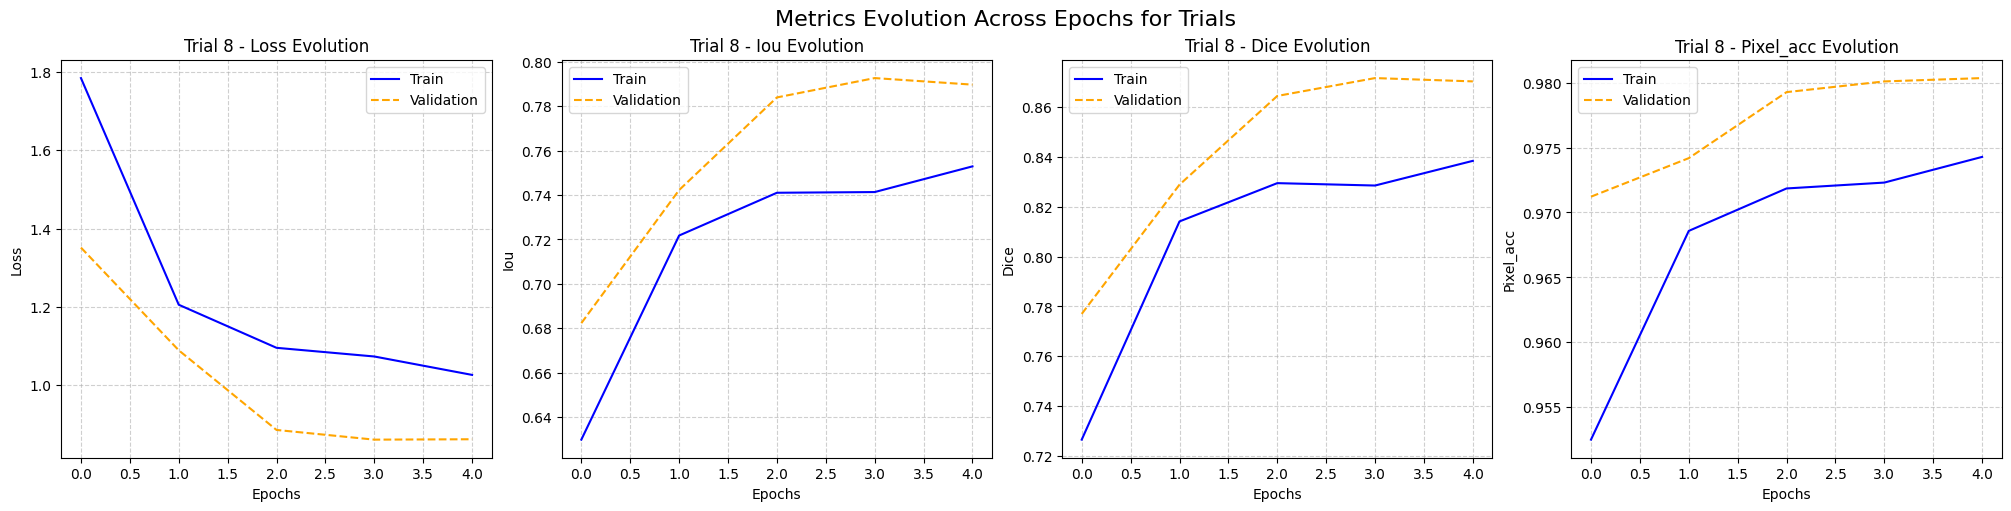

In [12]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

def plot_hyp_results(file_name, top_k=None):
    # Load data from pickle file
    with open(file_name, 'rb') as f:
        hyp_results_ = pickle.load(f)
    
    trial_metrics = hyp_results_["trial_metrics"]
    metrics_list = ['loss', 'iou', 'dice', 'pixel_acc']

    # Get the top_k
    included_i = np.argsort([t.value for t in hyp_results_['study'].get_trials()])[::-1][:top_k]
    
    # Create a figure with subplots
    num_trials = len(included_i)
    fig, axes = plt.subplots(num_trials, len(metrics_list), figsize=(20, 5 * num_trials), constrained_layout=True)
    
    # Ensure axes is a 2D array even if there's only one trial
    if num_trials == 1:
        axes = [axes]

    for i, trial_i in enumerate(included_i):
        if trial_i not in included_i: continue

        trial_data = trial_metrics[trial_i]
        train_metrics = trial_data['train']
        val_metrics = trial_data['val']
        
        for j, metric in enumerate(metrics_list):
            ax = axes[i][j]
            ax.plot(train_metrics[metric], label='Train', color='blue', linestyle='-')
            ax.plot(val_metrics[metric], label='Validation', color='orange', linestyle='--')
            
            # Titles and labels
            ax.set_title(f"Trial {trial_i + 1} - {metric.capitalize()} Evolution")
            ax.set_xlabel("Epochs")
            ax.set_ylabel(metric.capitalize())
            ax.legend()
            
            # Grid for better readability
            ax.grid(True, linestyle='--', alpha=0.6)
    
    # Set a main title for the entire figure
    fig.suptitle("Metrics Evolution Across Epochs for Trials", fontsize=16)
    plt.show()

# Example usage
file_name = "hyp_tuning_studies/final_hyp_results_2024-11-25_22-03-54.pkl"
plot_hyp_results(file_name, top_k=1)

In [1]:
import pickle

# Load data from pickle file
with open("./hyp_tuning_studies/final_hyp_results_2024-11-25_22-03-54.pkl", 'rb') as f:
    hyp_results_ = pickle.load(f)

In [8]:
study.best_params

{'criterion': 'scaled',
 'use_batches': 'false',
 'weight_decay': 0.0013032347157458826,
 'smooth': 0.31038665868329945,
 'threshold_low_loss': 21}

In [2]:
study = hyp_results_["study"]

# print the range of hyperparameters
params = {}
print("Hyperparameter Ranges:")
for trial in study.trials:
    for param_name, param_value in trial.distributions.items():
        if param_name not in params:
            params[param_name] = param_value

for param_name, param_values in params.items():
    print(f"{param_name}: {param_values}")

Hyperparameter Ranges:
criterion: CategoricalDistribution(choices=('combined', 'dice', 'scaled', 'boundary'))
use_batches: CategoricalDistribution(choices=('true', 'false'))
weight_decay: FloatDistribution(high=0.01, log=True, low=0.0001, step=None)
smooth: FloatDistribution(high=1.0, log=True, low=1e-06, step=None)
dice_weight_combined: FloatDistribution(high=0.9, log=False, low=0.1, step=None)
threshold_low_loss: IntDistribution(high=50, log=False, low=1, step=1)
boundary_weight: FloatDistribution(high=10.0, log=True, low=0.01, step=None)
batch_size: IntDistribution(high=16, log=False, low=4, step=1)
